In [1]:
import matplotlib.pyplot as plt
import numpy as np
# this is applied in jupyter notebook
% matplotlib inline

In [2]:
# load data
faces_train = np.loadtxt('faces_train.txt')
faces_train_labels = np.loadtxt('faces_train_labels.txt')
faces_test = np.loadtxt('faces_test.txt')
faces_test_labels = np.loadtxt('faces_test_labels.txt')

In [3]:
# look at the shape of data
print(faces_train.shape)  # 7 rows as 7 images for training 
print(faces_test.shape)  # 3 rows as 3 images for testing

(280, 1024)
(120, 1024)


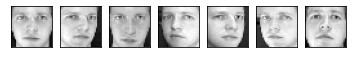

In [4]:
# show some images in the trainning data
def showImage1(data):
    plt.figure()
    for i in range(1, 8):
        plt.subplot(1, 7, i)
        # as it is not RGB but eigher R,G,or B, I can represent it with gray color(0-255 in one color channel)
        plt.imshow(data[i - 1, :].reshape(32, 32).T, cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()


showImage1(faces_train)

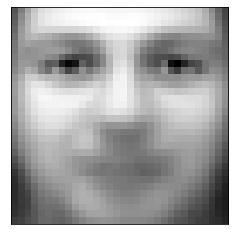

In [5]:
# find the mean face image
def meanImage(data):
    mean_vector = np.mean(data, axis=0)
    return mean_vector


def showImage2(data):
    pixel = int(np.sqrt(len(data)))
    plt.figure()
    plt.imshow(data.reshape(pixel, pixel).T, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()


mean_vector = meanImage(faces_train)
showImage2(mean_vector)

In [6]:
# compute eigenvalues and eigenvectors of scatter matrix:

def eigen(data):
    image_norm = data - meanImage(data)
    image_scatter = np.cov(image_norm, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(image_scatter)
    eigenIndex = np.argsort(eigenvalues)
    return eigenvalues, eigenvectors, eigenIndex


# perform PCA on the orginal image

def PCA(data, k_components):
    image_norm = data - meanImage(data)
    eigenvalues, eigenvectors, eigenIndex = eigen(data)
    # take k indexs of max eigenvalues so that we can pick k corresponding eigenvectors
    k_eigen = eigenIndex[-1:-(k_components + 1):-1]
    # choose the eigenvectors corresponding to the top k eigenvalues as our projection basis
    eigen_basis = eigenvectors[:, k_eigen].T
    image_new_representation = np.dot(eigen_basis, image_norm.T).T
    return eigen_basis, image_new_representation

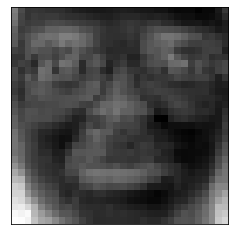

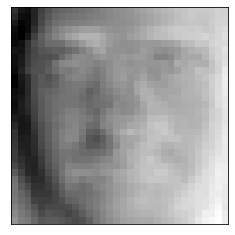

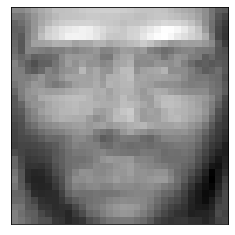

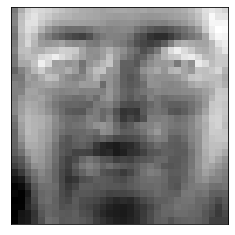

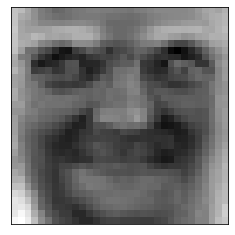

In [7]:
eigen_basis, image_new_representation = PCA(faces_train, 5)

# show top 5 eigenfaces computed by PCA
for k in range(5):
    showImage2(eigen_basis[k, :])

In [8]:
def reconstruction(faces_train, faces_test, k_components):
    # centralize test image with the mean of training image
    image_norm = faces_test - meanImage(faces_train)
    # find the reduced basis of training image
    eigen_basis, image_new_representation = PCA(faces_train, k_components)
    # project new image onto the reduced basis of training image
    image_new_test = eigen_basis.dot(image_norm.T)
    # reconstruct test image
    test_reconstruction = eigen_basis.T.dot(image_new_test).T + meanImage(faces_train)
    return test_reconstruction

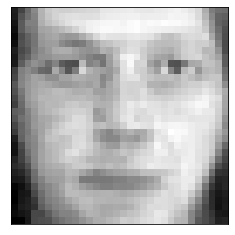

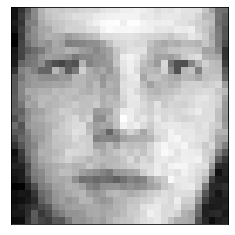

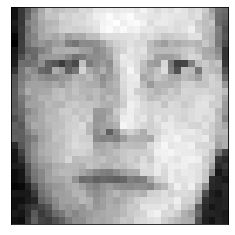

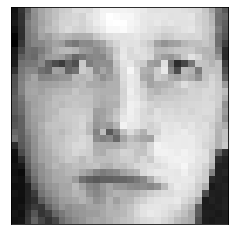

The following image is original image presentation 



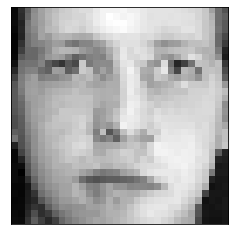

In [9]:
# 4 different K to reconstruct testing image
for k in [50, 300, 600, 1000]:
    recon = reconstruction(faces_train, faces_test, k)
    # take the first test image to look at
    showImage2(recon[0, :])

print('The following image is original image presentation \n')

showImage2(faces_test[0, :])
# comments of the result: 
# as k increased, the image becomes more and more close to original one 

In [10]:
def imageNN(faces_train, faces_train_labels, test_reconstruction):
    # class label
    labels = []
    for i in test_reconstruction:
        # calculate distance for each image
        distance = np.array([np.linalg.norm(i - j) for j in faces_train])
        # get the index of the nearest image 
        nn = np.argsort(-distance)[-1]
        # find the nearest image label
        nn_label = faces_train_labels[nn]
        labels.append(nn_label)
    return labels


def imageNN_Assess(faces_train, faces_train_labels, faces_test, faces_test_labels, k_components):
    # reconstruct test image based on the basis of training image
    test_reconstruction = reconstruction(faces_train, faces_test, k_components)
    # get class labels for each image
    labels = imageNN(faces_train, faces_train_labels, test_reconstruction)
    accurate_num = 0
    for i, j in zip(labels, faces_test_labels):
        # if classification is right, then accurate_num + 1
        if i == j:
            accurate_num += 1
    accuracy = round(accurate_num / len(faces_test_labels), 2)
    return accuracy

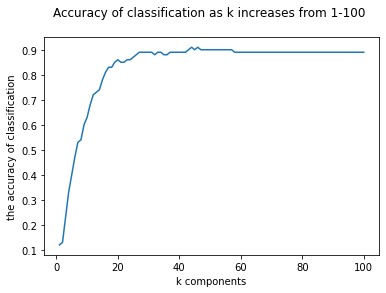

In [11]:
# show classification rate as k increased:
k_components = []
accuracies = []
# sample 50 different ks in ascending ording
# k_sample=sorted(np.random.choice(np.arange(1,1025),size=50,replace=False))
for k in range(1, 101):
    accuracy = imageNN_Assess(faces_train, faces_train_labels, faces_test, faces_test_labels, k)
    k_components.append(k)
    accuracies.append(accuracy)
plt.plot(k_components, accuracies)
plt.xlabel("k components")
plt.ylabel("the accuracy of classification")
plt.title("Accuracy of classification as k increases from 1-100 \n")
plt.show()


 Wrong Classified 5 pairs Images 



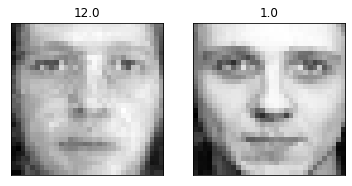

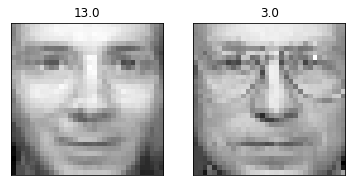

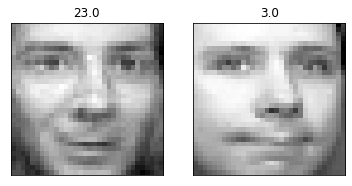

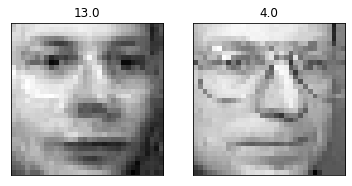

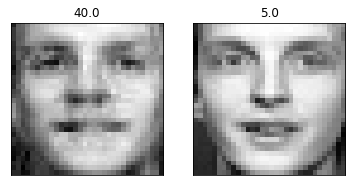

In [16]:
# images of incorrectly classified faces and their nearest neighbours from training set for k=100
def wrongClassified():
    test_reconstruction = reconstruction(faces_train, faces_test, 100)
    row = test_reconstruction.shape[0]
    count = 0
    for i in range(row):
        distance = np.array([np.linalg.norm(test_reconstruction[i] - j) for j in faces_train])
        nn = np.argsort(-distance)[-1]
        nn_label = faces_train_labels[nn]
        if nn_label != faces_test_labels[i] and count < 5:
            figure, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            test_image = test_reconstruction[i].reshape(32, 32).T
            ax1.imshow(test_image, cmap='gray')
            ax1.set_title(str(nn_label))
            ax1.set_xticks([])
            ax1.set_yticks([])
            train_image = faces_train[nn].reshape(32, 32).T
            ax2.imshow(train_image, cmap='gray')
            ax2.set_title(str(faces_test_labels[i]))
            ax2.set_xticks([])
            ax2.set_yticks([])
            plt.show()

            count += 1


print("\n Wrong Classified 5 pairs Images \n")
wrongClassified() 